## **Classifying and Grouping Products to Gain Marketing Knowledge**

**Milestone 1: Data Collection and Wrangling**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
path = "/content/drive/MyDrive/Colab Notebooks/pricerunner_aggregate.csv"
df = pd.read_csv(path)

# Data exploration
print("Initial Data Overview:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Handle missing values
print("\nChecking for Missing Values:")
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Convert problematic columns to numeric if possible
for col in df.select_dtypes(include=['object', 'string']).columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Converts to NaN if conversion fails
    except Exception as e:
        print(f"Skipping column {col}: {e}")

# Re-check for missing values and fill remaining numeric NaN values
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Select only numeric columns for Z-score calculation
numeric_data = df.select_dtypes(include=[np.number])

# Z-score calculation for numeric columns
z_scores = np.abs((numeric_data - numeric_data.mean()) / numeric_data.std())

# Remove rows with outliers (Z-score >= 3 in any numeric column)
df_no_outliers = df[(z_scores < 3).all(axis=1)]

# Check if data remains after outlier removal
if df_no_outliers.empty:
    print("Warning: No data remains after outlier removal. Adjusting Z-score threshold...")
    df_no_outliers = df[(z_scores < 4).all(axis=1)]

# Normalize product features
scaler = StandardScaler()
if not df_no_outliers.empty:
    features = df_no_outliers.select_dtypes(include=[np.number])
    scaled_features = scaler.fit_transform(features)
else:
    print("Error: No data available after outlier removal.")
    scaled_features = None

# Proceed with further steps if needed, such as saving or passing to next milestone
if scaled_features is not None and len(scaled_features) > 0:
    df_no_outliers_normalized = pd.DataFrame(scaled_features, columns=features.columns)
    # Optional: Save cleaned data
    df_no_outliers_normalized.to_csv("cleaned_data.csv", index=False)
    print("Cleaned dataset saved as 'cleaned_data.csv'")
else:
    print("Data is empty after outlier removal, no further processing.")

Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product ID       35311 non-null  int64 
 1   Product Title    35311 non-null  object
 2    Merchant ID     35311 non-null  int64 
 3    Cluster ID      35311 non-null  int64 
 4    Cluster Label   35311 non-null  object
 5    Category ID     35311 non-null  int64 
 6    Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB
None

Summary Statistics:
         Product ID   Merchant ID    Cluster ID   Category ID
count  35311.000000  35311.000000  35311.000000  35311.000000
mean   26150.800176    120.501883  30110.687633   2618.142930
std    13498.191220    117.045557  18410.265642      3.600708
min        1.000000      1.000000      1.000000   2612.000000
25%    14958.500000     17.000000   6123.000000   2615.000000
50%    27614.000

**Milestone 2: Product Clustering and Classification**

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Load dataset
df = pd.read_csv(path)

# Data Preprocessing: Fill missing values with the column mean for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Select numeric features for clustering
features = df.select_dtypes(include=[np.number])

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)




## Principal Component Analysis (PCA)

The data is made less dimensional by using Principal Component Analysis (PCA) to streamline the clustering process and enhance visualization.
PCA maintains as much variety as feasible when projecting high-dimensional data onto a two-dimensional environment.
They are better able to visualize the clusters as a result.

In [10]:
# Apply PCA to reduce dimensionality for visualization (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a new DataFrame with PCA results
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

## K-means Clustering

K-means clustering is used in this section to organize products into clusters according to their shared characteristics.
An iterative technique called K-means reduces the variation within each cluster.
I allocated each product to a cluster after setting the number of clusters to three (or any other amount determined by the project needs).
## Cluster Visualization with Seaborn

A scatter plot of the clusters produced by the K-means algorithm is made using Seaborn.
A product is represented by each point, and the principle components from PCA are represented by the x- and y-axes.
Color-coding products according to their cluster assignments allows us to visually distinguish different clusters.

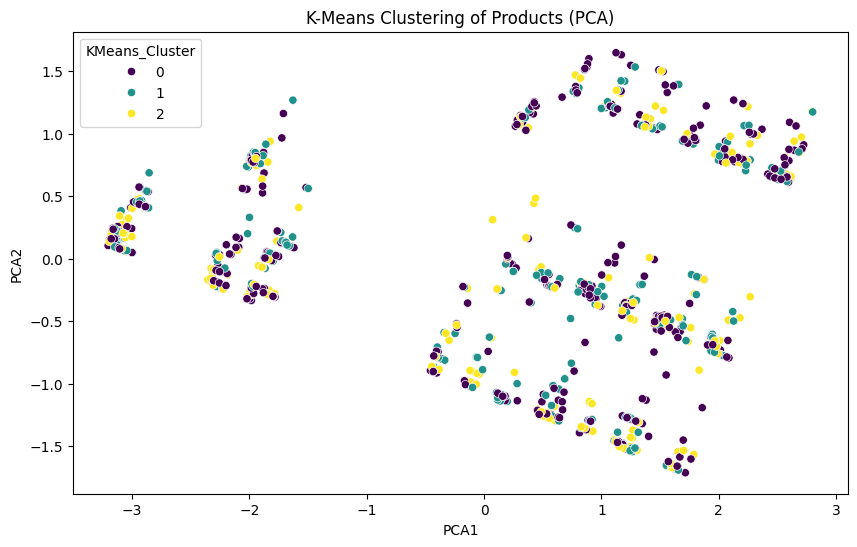

In [11]:
# Sample a subset of data if the dataset is too large (optional)
sample_size = 1000  # Adjust this size based on your dataset size
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform K-Means Clustering using MiniBatchKMeans for larger datasets
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)  # Using MiniBatchKMeans for efficiency
df_sampled['KMeans_Cluster'] = kmeans.fit_predict(scaled_features[:sample_size])

# Visualize K-Means Clusters using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df_sampled, palette='viridis')
plt.title('K-Means Clustering of Products (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

## Hierarchical Clustering

Here, I used Hierarchical Clustering to put products into groups according to how similar their features are.
This technique creates a hierarchy of clusters that a dendrogram may show.
To match the K-means results for comparison, we set the number of clusters to three.

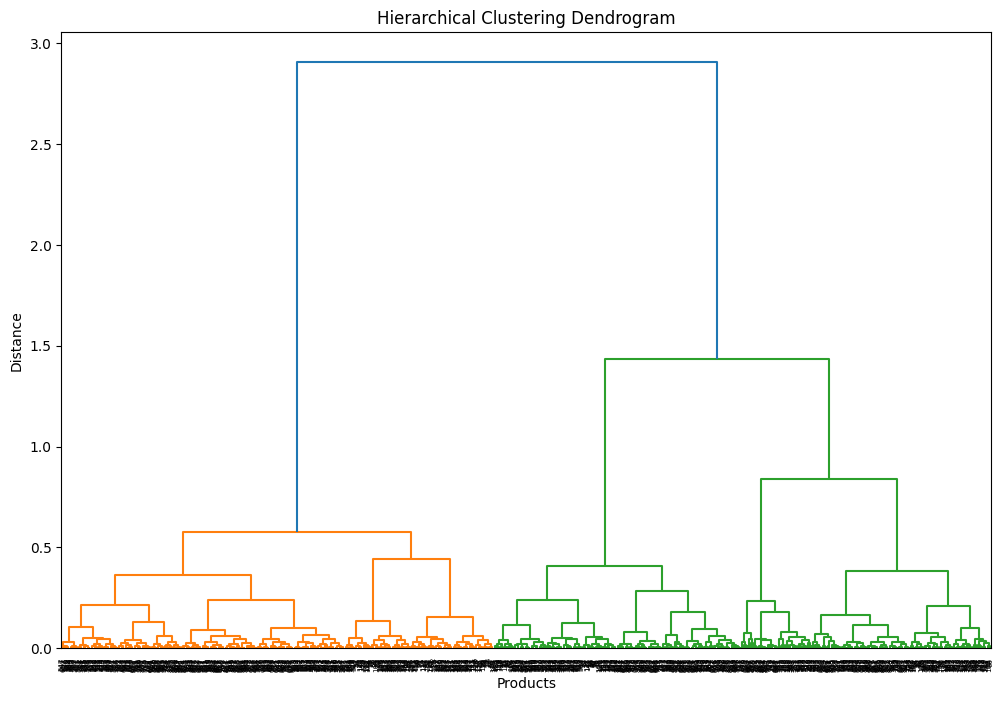

In [13]:
# Perform Hierarchical Clustering on a smaller subset (optional)
linkage_matrix = linkage(scaled_features[:sample_size], method='ward')  # Using only a subset for speed
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Products')
plt.ylabel('Distance')
plt.show()



## Interactive Visualization with Plotly

Here, a Hierarchical Clustering interactive scatter plot is made using Plotly.
With colors denoting cluster assignments and each point representing a product, this enables dynamic cluster exploration.
The cluster analysis is easier to understand when users can hover over points to get product details.

In [14]:
# Visualize Hierarchical Clustering using Plotly (Interactive Plot)
fig = px.scatter(df_sampled, x='PCA1', y='PCA2', color='KMeans_Cluster',
                 labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'},
                 title="Product Clusters Visualization")
fig.show()

**Milestone 3: Interactive Data Visualization**

In [4]:
!pip install dash
!pip install plotly
!pip install flask-ngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [8]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px
import plotly.figure_factory as ff
from flask_ngrok import run_with_ngrok  # For running the app through ngrok
import matplotlib.pyplot as plt
import base64 # For running the app through ngrok

# Load dataset
df = pd.read_csv(path)

# Data Preprocessing: Fill missing values with the column mean for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Select numeric features for clustering
features = df.select_dtypes(include=[np.number])

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA to reduce dimensionality for visualization (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a new DataFrame with PCA results
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Sample a subset of data if the dataset is too large (optional)
sample_size = 1000  # Adjust this size based on your dataset size
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform K-Means Clustering using MiniBatchKMeans for larger datasets
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)  # Using MiniBatchKMeans for efficiency
df_sampled['KMeans_Cluster'] = kmeans.fit_predict(scaled_features[:sample_size])

# Function to generate and save a dendrogram as an image
def generate_dendrogram_image(scaled_features_sampled, filename='dendrogram.png'):
    linkage_matrix = linkage(scaled_features_sampled, method='ward')
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=[str(i) for i in range(len(scaled_features_sampled))], leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Create a Dash app
app = dash.Dash(__name__)
run_with_ngrok(app)  # Expose the app through ngrok

# Create layout for the Dash app
app.layout = html.Div([
    html.H1('Interactive Product Clusters Dashboard'),

    # Dropdown for selecting the clustering method
    dcc.Dropdown(
        id='cluster-dropdown',
        options=[
            {'label': 'K-Means Clustering', 'value': 'kmeans'},
            {'label': 'Hierarchical Clustering', 'value': 'hierarchical'}
        ],
        value='kmeans',  # Default value
        style={'width': '50%'}
    ),

    # Scatter plot for K-Means
    dcc.Graph(id='cluster-plot'),

    # Dendrogram for hierarchical clustering (as an image)
    html.Img(id='dendrogram-img', style={'display': 'none'})
])

# Callback to update the cluster plot or dendrogram
@app.callback(
    [Output('cluster-plot', 'figure'),
     Output('cluster-plot', 'style'),
     Output('dendrogram-img', 'src'),
     Output('dendrogram-img', 'style')],
    [Input('cluster-dropdown', 'value')]
)
def update_visualization(selected_cluster_method):
    if selected_cluster_method == 'kmeans':
        # Generate K-Means scatter plot
        fig = px.scatter(df_sampled, x='PCA1', y='PCA2', color='KMeans_Cluster',
                         labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'},
                         title="K-Means Clusters")
        return fig, {'display': 'block'}, '', {'display': 'none'}  # Show K-Means, hide dendrogram

    elif selected_cluster_method == 'hierarchical':
        # Generate dendrogram
        sample_size_hierarchical = 1000
        df_sampled_hierarchical = df.sample(n=sample_size_hierarchical, random_state=42)
        scaled_features_sampled = scaler.fit_transform(df_sampled_hierarchical.select_dtypes(include=[np.number]))
        dendrogram_filename = 'dendrogram.png'
        generate_dendrogram_image(scaled_features_sampled, filename=dendrogram_filename)

        # Encode dendrogram as base64
        with open(dendrogram_filename, 'rb') as f:
            encoded_image = base64.b64encode(f.read()).decode('ascii')
            img_src = f"data:image/png;base64,{encoded_image}"

        return {}, {'display': 'none'}, img_src, {'display': 'block'}  # Show dendrogram, hide K-Means

# Run the app
# Run the app with ngrok
if __name__ == '__main__':
    app.run_server()



<IPython.core.display.Javascript object>

In [6]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px
import matplotlib.pyplot as plt
import base64

# Load dataset
df = pd.read_csv(path)

# Data Preprocessing: Fill missing values with the column mean for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Select numeric features for clustering
features = df.select_dtypes(include=[np.number])

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA to reduce dimensionality for visualization (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a new DataFrame with PCA results
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Sample a subset of data if the dataset is too large (optional)
sample_size = 1000  # Adjust this size based on your dataset size
df_sampled = df.sample(n=sample_size, random_state=42)

# Perform K-Means Clustering using MiniBatchKMeans for larger datasets
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)  # Using MiniBatchKMeans for efficiency
df_sampled['KMeans_Cluster'] = kmeans.fit_predict(scaled_features[:sample_size])

# Function to generate and save a dendrogram as an image
def generate_dendrogram_image(scaled_features_sampled, filename='dendrogram.png'):
    linkage_matrix = linkage(scaled_features_sampled, method='ward')
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=[str(i) for i in range(len(scaled_features_sampled))], leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Create a Dash app
app = dash.Dash(__name__)

# Create layout for the Dash app
app.layout = html.Div([
    html.H1('Interactive Product Clusters Dashboard'),

    # Dropdown for selecting the clustering method
    dcc.Dropdown(
        id='cluster-dropdown',
        options=[
            {'label': 'K-Means Clustering', 'value': 'kmeans'},
            {'label': 'Hierarchical Clustering', 'value': 'hierarchical'}
        ],
        value='kmeans',  # Default value
        style={'width': '50%'}
    ),

    # Scatter plot for K-Means
    dcc.Graph(id='cluster-plot'),

    # Dendrogram for hierarchical clustering (as an image)
    html.Img(id='dendrogram-img', style={'display': 'none'})
])

# Callback to update the cluster plot or dendrogram
@app.callback(
    [Output('cluster-plot', 'figure'),
     Output('cluster-plot', 'style'),
     Output('dendrogram-img', 'src'),
     Output('dendrogram-img', 'style')],
    [Input('cluster-dropdown', 'value')]
)
def update_visualization(selected_cluster_method):
    if selected_cluster_method == 'kmeans':
        # Generate K-Means scatter plot
        fig = px.scatter(df_sampled, x='PCA1', y='PCA2', color='KMeans_Cluster',
                         labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'},
                         title="K-Means Clusters")
        return fig, {'display': 'block'}, '', {'display': 'none'}  # Show K-Means, hide dendrogram

    elif selected_cluster_method == 'hierarchical':
        # Generate dendrogram
        sample_size_hierarchical = 1000
        df_sampled_hierarchical = df.sample(n=sample_size_hierarchical, random_state=42)
        scaled_features_sampled = scaler.fit_transform(df_sampled_hierarchical.select_dtypes(include=[np.number]))
        dendrogram_filename = 'dendrogram.png'
        generate_dendrogram_image(scaled_features_sampled, filename=dendrogram_filename)

        # Encode dendrogram as base64
        with open(dendrogram_filename, 'rb') as f:
            encoded_image = base64.b64encode(f.read()).decode('ascii')
            img_src = f"data:image/png;base64,{encoded_image}"

        return {}, {'display': 'none'}, img_src, {'display': 'block'}  # Show dendrogram, hide K-Means

# Run the app
if __name__ == '__main__':
    app.run_server(debug=False, use_reloader=False)

<IPython.core.display.Javascript object>